## LAB 05 - Vulnerability Classification with NN

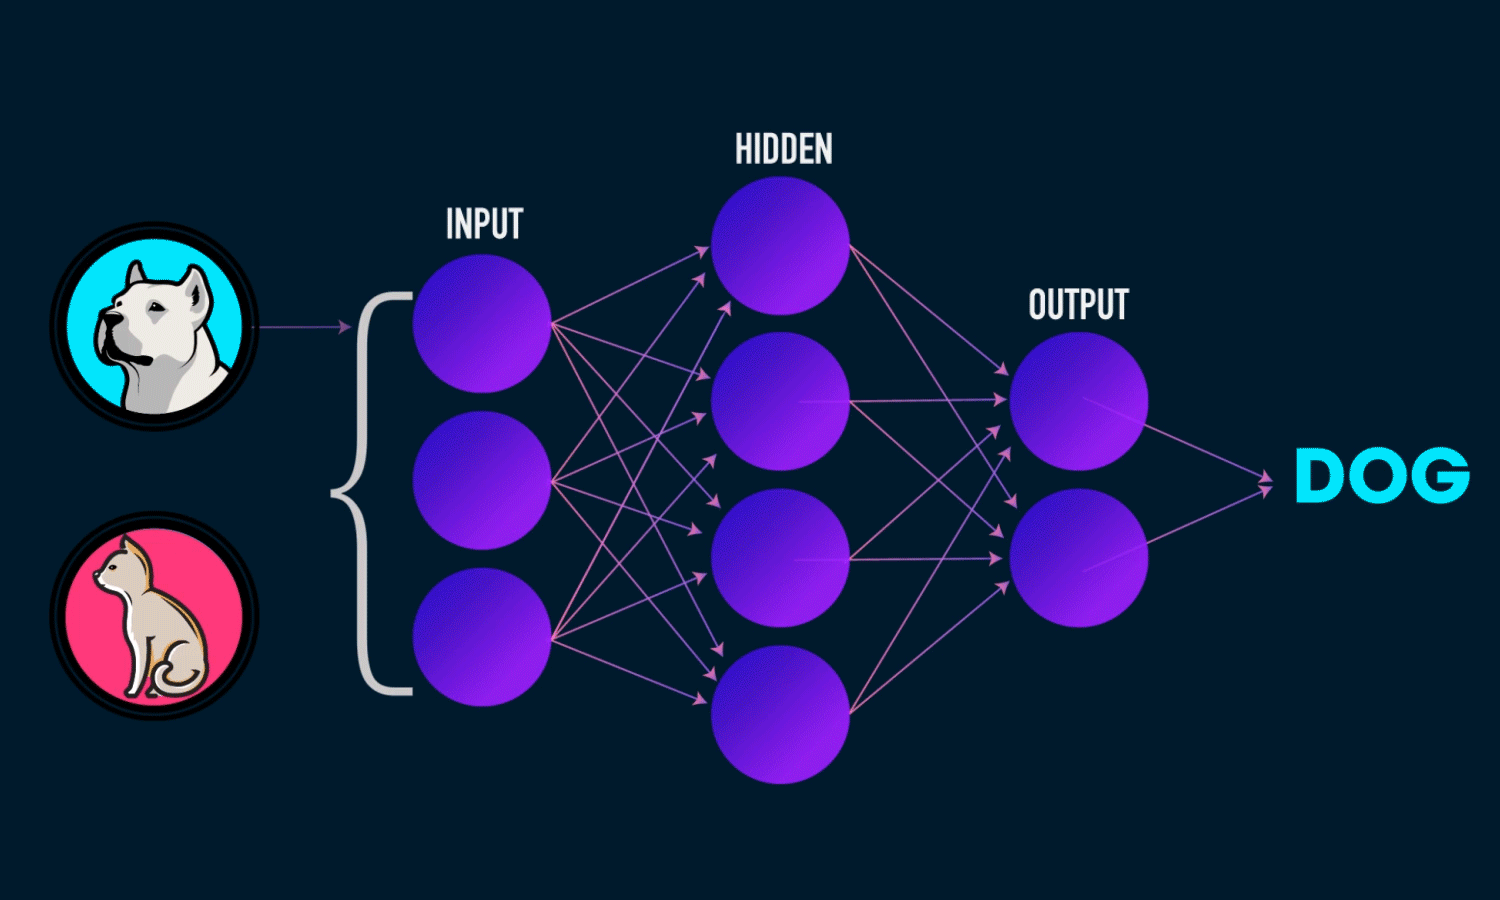

#### IMPORTS

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from sklearn import model_selection
import keras
from keras import optimizers

In [7]:
# Download the dataset
#!wget "https://homepages.dcc.ufmg.br/~arturluis/202ds/2020cvss.csv" --no-check-certificate -nc

--2022-01-03 21:47:42--  https://homepages.dcc.ufmg.br/~arturluis/202ds/2020cvss.csv
Resolving homepages.dcc.ufmg.br (homepages.dcc.ufmg.br)... 150.164.0.136
Connecting to homepages.dcc.ufmg.br (homepages.dcc.ufmg.br)|150.164.0.136|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 563945 (551K) [text/csv]
Saving to: ‘2020cvss.csv’

2020cvss.csv        100%[===================>] 550,73K  2,34MB/s    in 0,2s    

2022-01-03 21:47:44 (2,34 MB/s) - ‘2020cvss.csv’ saved [563945/563945]



,Unnamed: 0,attackVector,attackComplexity,privilegesRequired,userInteraction,confidentialityImpact,integrityImpact,availabilityImpact,label
0,0,0.55,0.44,0.62,0.85,0.66,0.66,0.66,1
1,1,0.85,0.44,0.85,0.62,0.66,0.66,0.66,1
2,2,0.55,0.77,0.62,0.62,0.66,0.66,0.66,0
3,3,0.55,0.44,0.62,0.85,0.00,0.00,0.66,0
4,4,0.55,0.44,0.27,0.85,0.66,0.66,0.66,0


In [2]:
# Read it and print the first five rows
cvss_data = pd.read_csv('2020cvss.csv')
cvss_data["label"] = (cvss_data["label"] >= 2).astype(int)
cvss_data = cvss_data.drop(columns=["Unnamed: 0"])
cvss_data.head()

,attackVector,attackComplexity,privilegesRequired,userInteraction,confidentialityImpact,integrityImpact,availabilityImpact,label
0,0.55,0.44,0.62,0.85,0.66,0.66,0.66,1
1,0.85,0.44,0.85,0.62,0.66,0.66,0.66,1
2,0.55,0.77,0.62,0.62,0.66,0.66,0.66,0
3,0.55,0.44,0.62,0.85,0.00,0.00,0.66,0
4,0.55,0.44,0.27,0.85,0.66,0.66,0.66,0


## 1 - First, define your neural network. Create a network with 2 layers. Use 16 neurons in the hidden layer. See how many trainable parameters there are in your network.

### Neurons

The core component of a neural network are the [Neurons](https://victorzhou.com/blog/intro-to-neural-networks/). Similar to our brain, neural networks are composed of several interconnected neurons. Each of these neurons receives multiple signals as input, aggregates these inputs, and then output a new signal. 

In practice, a neuron receives input values, multiplies each input by a weight, sums these products and then adds a bias term: 


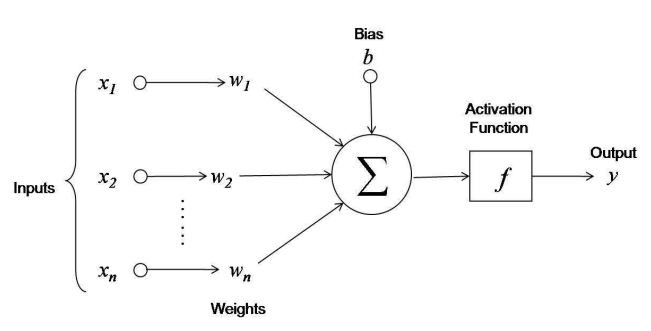

The values of the weights and the bias term are learned during the training process. This allows the neuron to learn which inputs are more important and how they affect the output. For instance, when predicting whether an animal is a cat or a dog, the neuron may learn that the ears of the animal are more important to determine if it's a cat or a dog than the tail.

A neuron can receive any number of inputs and will produce a single output. Let's take a quick look at how a neuron works in practice. Let's implement a neuron and see it working in practice:

In [4]:
#inputs = 8 considering label
#inputs = 7 not considering label
#bias = 0
#
weights = [np.round(1/7,3)]*7
weights


[0.143, 0.143, 0.143, 0.143, 0.143, 0.143, 0.143]

In [5]:
bias = 0
def sigmoid(x):
  # Our activation function: f(x) = 1 / (1 + e^(-x))
  return 1 / (1 + np.exp(-x))

class Neuron:
  def __init__(self, weights, bias):
    self.weights = weights
    self.bias = bias

  def feedforward(self, inputs):
    # Weight inputs, add bias, then use the activation function
    total = np.dot(self.weights, inputs) + self.bias
    return sigmoid(total)


n = Neuron(weights, bias)
x = np.array([0.55, 0.44, 0.62, 0.85, 0.66, 0.66,0.66]) 
print(np.round(n.feedforward(x),6)) 

0.653604


That's it! The operation of a neuron can be implemented with a single line of code. In practice, what our neuron did was:

$y = inputs \times weights + bias = (0.55 + 0.44 + 0.62 + 0.85 + 0.66 + 0.66 + 0.66)\times0.143 + 0 = 0.653604$

A simple mathematical operation to generate the output, that's what the neuron does. 

As we will see next, however, the neurons employed in neural networks are often paired with a second component: the **activation function**.

In [6]:
num_features = 7
num_classes = 4
model = Sequential(name="2layer_NN")
model.add(Dense(12, input_dim=num_features, activation='sigmoid'))
model.add(Dense(4, activation='sigmoid'))
model.summary()

Model: "2layer_NN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                96        
                                                                 
 dense_1 (Dense)             (None, 4)                 52        
                                                                 
Total params: 148
Trainable params: 148
Non-trainable params: 0
_________________________________________________________________


## 2 - Split the dataset into training and test sets and train your network in the training set. Train your network for 10 epochs and set the learning rate to 0.1.


## Training a Neural Network with Keras

We have gone through each of the components of a neural network, from the structure of a neuron, to the activation function, to how we measure performance and use that to train the network. However, we did that for a network with a single neuron. A proper network instead has a multitude of neurons. In fact, neural networks are often organized in layers, with each layer containing several neurons. For instance:


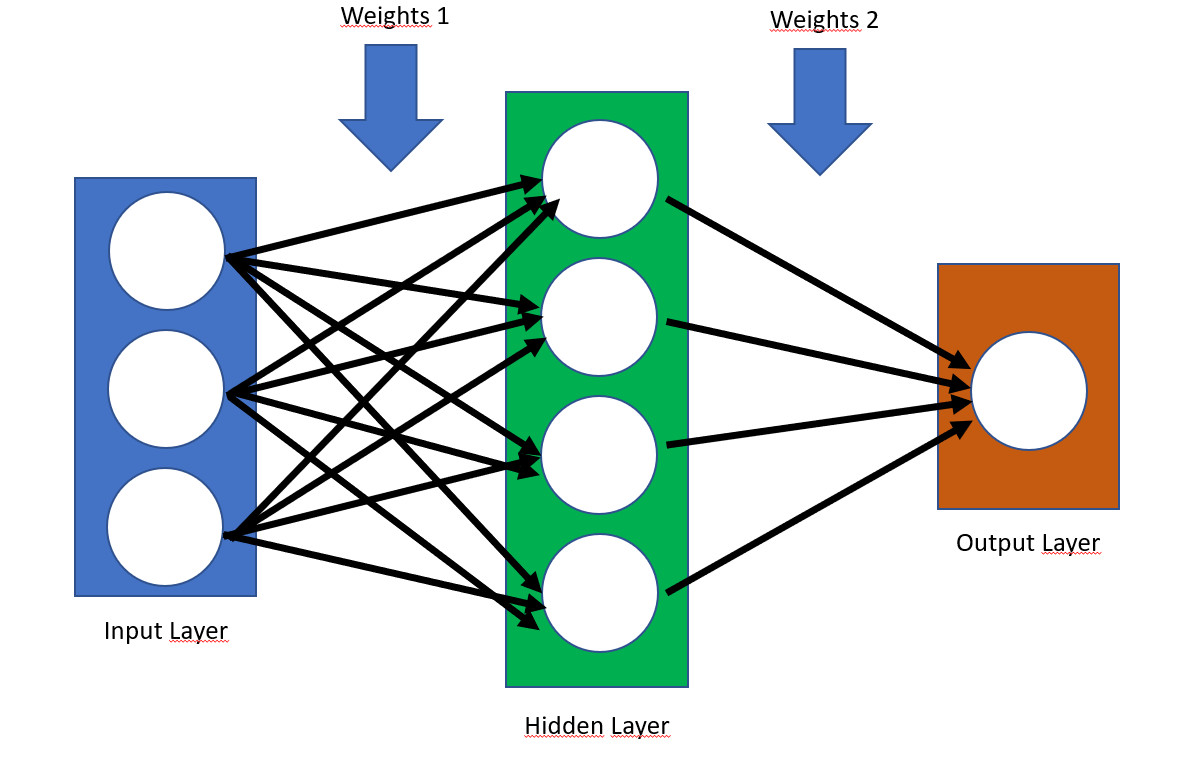

This is the illustration of a neural network with 2 layers (we do not count the input layer). The first layer, called hidden layer, has 4 neurons, while the second layer, the output layer, has a single neuron. In this network, each input will traverse the sequence of layers we defined until we achieve an output. The outputs of one layer behave as inputs to the next. This is known as a feedforward neural network.

Everything in this neural network behaves the same, or similarly, to what we just saw. Each neuron follows the exact structure of the neuron in our single-neuron neural network. There is an activation function after each neuron to ensure non-linearity. Each neuron has a set of weights, which are updated using backpropagation, according to a loss function.

In [86]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(cvss_data[['attackVector', 'attackComplexity', 'privilegesRequired','userInteraction','confidentialityImpact','integrityImpact','availabilityImpact']].values, cvss_data['label'].values, test_size=0.2)

opt = tf.keras.optimizers.SGD(learning_rate=0.1) # Use gradient descent with learning_rate=0.1
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=opt)
#np.asarray(train_labels).astype('float32').reshape((-1,1))
#len(X_train) = len(y_train) = 11452 antes de usar o reshape
X_train = np.reshape(X_train,(11452,7))
# https://towardsdatascience.com/get-into-shape-14637fe1cd32 - leitura mais aprofundada para tentar entender
#y_train = np.asarray(y_train).reshape((-1,1))
y_train.shape

#após utilizar o reshape temos 
#y_train = 11452 e x_train = 80164
#model.fit(np.asarray(X_train), np.asarray(y_train), epochs=10, verbose=1, batch_size=1)
#model.fit(X_train, y_train, epochs=10, verbose=1, batch_size=1)

(11452,)

In [77]:
np.round(X_train[0],2)

array([0.54, 0.  , 0.62, 0.85, 0.66, 0.66, 0.66])

In [87]:
model.fit(X_train, y_train, epochs=10, verbose=1, batch_size=1)

Epoch 1/10


ValueError: in user code:

    File "/home/gimpel/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/home/gimpel/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/gimpel/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/home/gimpel/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 809, in train_step
        loss = self.compiled_loss(
    File "/home/gimpel/anaconda3/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/gimpel/anaconda3/lib/python3.8/site-packages/keras/losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/gimpel/anaconda3/lib/python3.8/site-packages/keras/losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/gimpel/anaconda3/lib/python3.8/site-packages/keras/losses.py", line 1807, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/home/gimpel/anaconda3/lib/python3.8/site-packages/keras/backend.py", line 5158, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)

    ValueError: `logits` and `labels` must have the same shape, received ((1, 4) vs (1, 1)).


In [ ]:
#	attackVector	attackComplexity	privilegesRequired	userInteraction	confidentialityImpact	integrityImpact	availabilityImpact

## 3 - Test your network using the test set. 

In [78]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

ValueError: in user code:

    File "/home/gimpel/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1366, in test_function  *
        return step_function(self, iterator)
    File "/home/gimpel/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1356, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/gimpel/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1349, in run_step  **
        outputs = model.test_step(data)
    File "/home/gimpel/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1305, in test_step
        self.compiled_loss(
    File "/home/gimpel/anaconda3/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/gimpel/anaconda3/lib/python3.8/site-packages/keras/losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/gimpel/anaconda3/lib/python3.8/site-packages/keras/losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/gimpel/anaconda3/lib/python3.8/site-packages/keras/losses.py", line 1807, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/home/gimpel/anaconda3/lib/python3.8/site-packages/keras/backend.py", line 5158, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)

    ValueError: `logits` and `labels` must have the same shape, received ((None, 4) vs (None, 1)).


## 4 - Try retraining your network with learning rates 0.001 and 10. What happens to the loss and accuracy?